<a href="https://colab.research.google.com/github/BrajanNieto/stats-prob-py/blob/main/99.%20PilotoAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
from google.colab import files
import io
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.linalg import svd
from scipy import stats

Importar Datos

In [47]:
# 1. Sube el archivo
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print(f"Archivo subido: {file_name}")
df_encuesta = pd.read_excel(io.BytesIO(uploaded[file_name]), sheet_name='Encuesta')


df_encuesta.head()

Saving Especialista_Encuesta Formato (1).xlsx to Especialista_Encuesta Formato (1) (2).xlsx
Archivo subido: Especialista_Encuesta Formato (1) (2).xlsx


,Id,Tipo,Sexo,Edad (Años),Establecimiento de Salud,Profesión,Años de experiencia,Meses de experiencia,Experiencia en,I1,...,D15,D16,D17,D18,D19,D20,D21,D_Total,D_Clase,D_Categoria
0,1,Piloto,Femenino,50,Ciudad Nueva,Enfermera,21,2.0,Coordinación,1,...,1,1,1,1,1,1,1,21,1,Respuesta alta
1,2,Piloto,Femenino,55,Ciudad Nueva,Enfermera,25,2.0,Coordinación,1,...,1,1,1,1,1,1,0,20,1,Respuesta alta
2,3,Piloto,Femenino,44,Ciudad Nueva,Enfermera,12,6.0,Dirección,1,...,1,1,1,1,1,1,0,18,1,Respuesta alta
3,4,Piloto,Femenino,49,Ciudad Nueva,Enfermera,21,10.0,Operación,0,...,1,1,1,1,1,1,0,18,1,Respuesta alta
4,5,Piloto,Femenino,42,Ciudad Nueva,Técnica en enfermería,8,0.0,Operación,1,...,1,1,1,1,1,1,1,21,1,Respuesta alta


# Análisis del Piloto

In [48]:
#df_piloto = df_encuesta[df_encuesta['Tipo'] == 'Piloto']
df_piloto = df_encuesta
print("Descripción estadística de df_piloto:")
print(df_piloto.describe(include='all'))

Descripción estadística de df_piloto:
               Id           Tipo      Sexo  Edad (Años)  \
count   78.000000             78        78    78.000000   
unique        NaN              3         3          NaN   
top           NaN  La Esperanza   Femenino          NaN   
freq          NaN             35        68          NaN   
mean    14.538462            NaN       NaN    50.025641   
std      9.123528            NaN       NaN    10.966270   
min      1.000000            NaN       NaN    30.000000   
25%      7.000000            NaN       NaN    42.250000   
50%     13.500000            NaN       NaN    50.000000   
75%     21.000000            NaN       NaN    59.750000   
max     35.000000            NaN       NaN    68.000000   

       Establecimiento de Salud                Profesión  Años de experiencia  \
count                         78                      78            78.000000   
unique                         3                       5                  NaN   
top       

In [49]:
print("\nNulos por columna en df_piloto:")
print(df_piloto.isnull().sum())


Nulos por columna en df_piloto:
Id                           0
Tipo                         0
Sexo                         0
Edad (Años)                  0
Establecimiento de Salud     0
Profesión                    0
Años de experiencia          0
Meses de experiencia         3
Experiencia en               0
I1                           0
I2                           0
I3                           0
I4                           0
I5                           0
I6                           0
I7                           0
I8                           0
I9                           0
I10                          0
I11                          0
I12                          0
I13                          0
I14                          0
I15                          0
I16                          0
I_Total                      0
I_Clase                      0
I_Categoria                  0
D1                           0
D2                           0
D3                           0
D4    

In [50]:
print("\nColumnas de df_piloto:")
print(", ".join(df_piloto.columns))


Columnas de df_piloto:
Id, Tipo, Sexo, Edad (Años), Establecimiento de Salud , Profesión, Años de experiencia, Meses de experiencia, Experiencia en , I1, I2, I3, I4, I5, I6, I7, I8, I9, I10, I11, I12, I13, I14, I15, I16, I_Total, I_Clase, I_Categoria, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, D16, D17, D18, D19, D20, D21, D_Total, D_Clase, D_Categoria


## Validación del Constructo

### Bartlett

In [51]:
# ─────────────────────────────────────────────
# 1.  Test de esfericidad de Bartlett
# ─────────────────────────────────────────────
def bartlett_sphericity(df: pd.DataFrame,
                        items: list[str],
                        *,
                        verbose: bool = True):
    """
    χ² de Bartlett para una lista de ítems.
    --------------------------------------
    Retorna: (chi_cuadrado, grados_libertad, p_valor, const_cols_eliminadas)
    """
    data = df[items].astype(float).dropna()

    # 1. Quitar columnas constantes
    const_cols = data.columns[data.nunique() == 1].tolist()
    if const_cols and verbose:
        print(f"[Bartlett] Columnas constantes eliminadas: {const_cols}")
    data = data.drop(columns=const_cols)

    n, p = data.shape
    if p < 2:
        raise ValueError("Quedaron <2 ítems tras eliminar constantes.")
    if n <= p:
        raise ValueError("n ≤ p: la matriz de correlaciones no es invertible.")

    # 2. Matriz de correlaciones
    R = data.corr()

    # 3. Estadístico de Bartlett
    det_R = np.linalg.det(R)
    if det_R <= 0:
        raise ValueError("Determinante ≤ 0: matriz singular o no positiva definida.")
    chi_square = -(n - 1 - (2 * p + 5) / 6) * np.log(det_R)
    dof = p * (p - 1) / 2
    p_val = 1 - chi2.cdf(chi_square, dof)

    return chi_square, dof, p_val, const_cols


### KMO

In [52]:
# ─────────────────────────────────────────────
# 2.  Índice KMO global e individual
# ─────────────────────────────────────────────
def kmo_test(df: pd.DataFrame,
             items: list[str],
             *,
             verbose: bool = True):
    """
    KMO global y por ítem.
    ----------------------
    Retorna: (kmo_global, serie_kmo_individual, const_cols_eliminadas)
    """
    data = df[items].astype(float).dropna()

    # 1. Quitar columnas constantes
    const_cols = data.columns[data.nunique() == 1].tolist()
    if const_cols and verbose:
        print(f"[KMO] Columnas constantes eliminadas: {const_cols}")
    data = data.drop(columns=const_cols)

    n, p = data.shape
    if p < 2:
        raise ValueError("Quedaron <2 ítems tras eliminar constantes.")
    if n <= p:
        raise ValueError("n ≤ p: la matriz de correlaciones no es invertible.")

    # 2. Matriz de correlaciones
    R = data.corr()

    # 3. Matriz de correlaciones parciales
    inv_R = np.linalg.inv(R)
    partial = -inv_R / np.sqrt(np.outer(np.diag(inv_R), np.diag(inv_R)))
    np.fill_diagonal(partial, 0)

    # 4. KMO global
    corr_sq = (R.values[np.triu_indices(p, 1)] ** 2).sum()
    part_sq = (partial[np.triu_indices(p, 1)] ** 2).sum()
    kmo_global = corr_sq / (corr_sq + part_sq)

    # 5. KMO por ítem
    kmo_individual = {}
    for i, col in enumerate(R.columns):
        corr_sq_i = (R.iloc[i, :].drop(index=col) ** 2).sum()
        part_sq_i = (partial[i, :] ** 2).sum()
        kmo_individual[col] = corr_sq_i / (corr_sq_i + part_sq_i)

    kmo_series = pd.Series(kmo_individual, name="KMO_individual")

    return kmo_global, kmo_series, const_cols

In [53]:
# ─────────────────────────────────────────────
# 3.  Alfa de Cronbach
# ─────────────────────────────────────────────
def cronbach_alpha(df: pd.DataFrame,
                   items: list[str],
                   *,
                   verbose: bool = True):
    """
    Alfa de Cronbach global y por ítem (α-if-deleted).
    --------------------------------------------------
    Retorna: (alpha_global, serie_alpha_if_deleted, const_cols_eliminadas)
    """
    data = df[items].astype(float).dropna()

    # 1. Quitar columnas constantes
    const_cols = data.columns[data.nunique() == 1].tolist()
    if const_cols and verbose:
        print(f"[Cronbach] Columnas constantes eliminadas: {const_cols}")
    data = data.drop(columns=const_cols)

    n, p = data.shape
    if p < 2:
        raise ValueError("Quedaron <2 ítems tras eliminar constantes.")

    # 2. Alfa global
    item_vars = data.var(ddof=1)
    total_score = data.sum(axis=1)
    total_var = total_score.var(ddof=1)
    if total_var == 0:
        raise ValueError("Varianza total = 0: los ítems suman un valor constante.")
    alpha_global = (p / (p - 1)) * (1 - item_vars.sum() / total_var)

    # 3. Alfa si se elimina cada ítem
    alpha_if_deleted = {}
    for col in data.columns:
        remaining = data.drop(columns=[col])
        p_rem = p - 1
        item_vars_rem = remaining.var(ddof=1)
        total_score_rem = remaining.sum(axis=1)
        total_var_rem = total_score_rem.var(ddof=1)
        if total_var_rem == 0:
            alpha_if_deleted[col] = np.nan
        else:
            alpha_if_deleted[col] = (p_rem / (p_rem - 1)) * (
                1 - item_vars_rem.sum() / total_var_rem
            )

    alpha_series = pd.Series(alpha_if_deleted, name="alpha_if_deleted")

    return alpha_global, alpha_series, const_cols

### Analisis del constructo

In [54]:
# Definición de ítems para cada escala

vdependiente1_cols = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15','D16','D17','D18','D19','D20','D21'] # Se cambia por colinealidad
#vdependiente1_cols = ['D2','D4','D10','D11','D13','D21']
vindependiente1_cols = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13','I14','I15','I16']
#vindependiente1_cols = ['I1','I2','I7','I8','I9','I11','I12']
# 1. Variable dependiente (cAPACIDAD DE RESPUESTA)
print("Análisis del constructo /n")

print("Variable dependiente /n")
chi2_dv, dof_dv, p_b_dv, const_b_dv = bartlett_sphericity(df_piloto, vdependiente1_cols)
print(f"[Dependiente] Bartlett χ²({int(dof_dv)}) = {chi2_dv:.2f}, p = {p_b_dv:.5e}")
kmo_g_dv, kmo_i_dv, const_k_dv = kmo_test(df_piloto, vdependiente1_cols)
print(f"[Dependiente] KMO global = {kmo_g_dv:.3f}")
print("[Dependiente] KMO individual:")
print(kmo_i_dv.round(3))
# — Alfa de Cronbach
alpha_dv, alpha_if_del_dv, const_a_dv = cronbach_alpha(df_piloto, vdependiente1_cols)
print(f"[Dependiente] Cronbach α = {alpha_dv:.3f}")
print("[Dependiente] α si se elimina el ítem:")
print(alpha_if_del_dv.round(3))

print("Variable independiente /n")

print('NIVEL DE CONOCIMIENTO-SISMO')

# 2. Independiente 1 (NIVEL DE CONOCIMIENTO /SISMO)
chi2_i1, dof_i1, p_b_i1, const_b_i1 = bartlett_sphericity(df_piloto, vindependiente1_cols)
print(f"[Indep1] Bartlett χ²({int(dof_i1)}) = {chi2_i1:.2f}, p = {p_b_i1:.5e}")
kmo_g_i1, kmo_i_i1, const_k_i1 = kmo_test(df_piloto, vindependiente1_cols)
print(f"[Indep1] KMO global = {kmo_g_i1:.3f}")
print("[Indep1] KMO individual:")
print(kmo_i_i1.round(3))
# — Alfa de Cronbach
alpha_dv, alpha_if_del_dv, const_a_dv = cronbach_alpha(df_piloto, vindependiente1_cols)
print(f"[Dependiente] Cronbach α = {alpha_dv:.3f}")
print("[Dependiente] α si se elimina el ítem:")
print(alpha_if_del_dv.round(3))

Análisis del constructo /n
Variable dependiente /n
[Dependiente] Bartlett χ²(210) = 1027.59, p = 0.00000e+00
[Dependiente] KMO global = 0.486
[Dependiente] KMO individual:
D1     0.691
D2     0.534
D3     0.394
D4     0.668
D5     0.465
D6     0.455
D7     0.272
D8     0.404
D9     0.454
D10    0.756
D11    0.273
D12    0.282
D13    0.624
D14    0.461
D15    0.478
D16    0.600
D17    0.781
D18    0.642
D19    0.677
D20    0.476
D21    0.188
Name: KMO_individual, dtype: float64
[Dependiente] Cronbach α = 0.782
[Dependiente] α si se elimina el ítem:
D1     0.779
D2     0.773
D3     0.770
D4     0.784
D5     0.769
D6     0.768
D7     0.781
D8     0.778
D9     0.775
D10    0.777
D11    0.777
D12    0.784
D13    0.781
D14    0.762
D15    0.773
D16    0.773
D17    0.752
D18    0.753
D19    0.781
D20    0.759
D21    0.785
Name: alpha_if_deleted, dtype: float64
Variable independiente /n
NIVEL DE CONOCIMIENTO-SISMO
[Indep1] Bartlett χ²(120) = 221.62, p = 4.84975e-08
[Indep1] KMO global = 0.515


In [40]:
corr = df_piloto[vdependiente1_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
duplicates = [(col, upper[col][upper[col] >= 0.8].index.tolist())
              for col in upper.columns if any(upper[col] >= 0.8)]
print("Ítems casi duplicados (correlación ≥ 0.80):", duplicates)


Ítems casi duplicados (correlación ≥ 0.80): []


In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 1. Filas completas usadas para la correlación
df_complete = df_piloto[vdependiente1_cols].dropna()
n_rows = df_complete.shape[0]
n_items = len(vdependiente1_cols)
print(f"Observaciones completas: {n_rows}, ítems: {n_items}")

# 2. Matriz de correlación
R = df_complete.corr()
R_values = R.values

# 3. Número de condición
cond_number = np.linalg.cond(R_values)
print("Número de condición de R:", cond_number)

# 4. Eigenvalores
eigenvals = np.linalg.eigvalsh(R_values)  # simétrica
print("Eigenvalores de R:", np.round(eigenvals, 5))

# 5. VIF por ítem (requiere que no haya multicolinealidad perfecta)
# Se usa la matriz de diseño: add a small constant if singularity occurs
vif_df = pd.DataFrame({
    "item": vdependiente1_cols,
    "VIF": [
        variance_inflation_factor(df_complete.values, i)
        if df_complete.shape[0] > 0 else np.nan
        for i in range(n_items)
    ]
})
print("\nVIF por ítem:")
print(vif_df)

Observaciones completas: 17, ítems: 10
Número de condición de R: 4.948480541899974e+16
Eigenvalores de R: [-0.      -0.       0.16042  0.25224  0.56667  0.5798   1.18765  1.87761
  2.36681  3.00881]

VIF por ítem:
  item        VIF
0   D2  40.421053
1   D3        inf
2   D4   2.089783
3  D10   1.733746
4  D11   3.390093
5  D13   2.089783
6  D16        inf
7  D19        inf
8  D20        inf
9  D21   2.925697


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 1. Filas completas usadas para la correlación
df_complete = df_piloto[vindependiente1_cols].dropna()
n_rows = df_complete.shape[0]
n_items = len(vindependiente1_cols)
print(f"Observaciones completas: {n_rows}, ítems: {n_items}")

# 2. Matriz de correlación
R = df_complete.corr()
R_values = R.values

# 3. Número de condición
cond_number = np.linalg.cond(R_values)
print("Número de condición de R:", cond_number)

# 4. Eigenvalores
eigenvals = np.linalg.eigvalsh(R_values)  # simétrica
print("Eigenvalores de R:", np.round(eigenvals, 5))

# 5. VIF por ítem (requiere que no haya multicolinealidad perfecta)
# Se usa la matriz de diseño: add a small constant if singularity occurs
vif_df = pd.DataFrame({
    "item": vindependiente1_cols,
    "VIF": [
        variance_inflation_factor(df_complete.values, i)
        if df_complete.shape[0] > 0 else np.nan
        for i in range(n_items)
    ]
})
print("\nVIF por ítem:")
print(vif_df)

Observaciones completas: 17, ítems: 14
Número de condición de R: 4.300274611627203e+16
Eigenvalores de R: [-0.      -0.       0.00754  0.04781  0.13055  0.25815  0.28657  0.3277
  0.76318  1.13319  1.32841  2.71004  3.05757  3.94931]

VIF por ítem:
   item        VIF
0    I1   2.647059
1    I2   5.294118
2    I3        inf
3    I4        inf
4    I5  24.444444
5    I6        inf
6    I7        inf
7    I8  89.500000
8    I9  99.111111
9   I10        inf
10  I11   3.705882
11  I12  54.444444
12  I13        inf
13  I14        inf


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [55]:

def varimax(loadings, gamma=1.0, q=20, tol=1e-6):
    R = np.eye(loadings.shape[1])
    for _ in range(q):
        lam = loadings @ R
        u, _, v = svd(loadings.T @ (lam**3 - (gamma / loadings.shape[0]) *
                                    lam @ np.diag(np.sum(lam**2, axis=0))))
        R_new = u @ v
        if np.max(np.abs(R - R_new)) < tol:
            break
        R = R_new
    return loadings @ R, R

def pca_report(df, cols, variance_threshold=0.80, rotate=True, random_state=None):
    X = df[cols].copy()

    # 1. Quitar columnas constantes y filas con NA
    const_cols = X.columns[X.nunique() <= 1].tolist()
    if const_cols:
        print(f"[PCA] columnas constantes eliminadas: {const_cols}")
        X = X.drop(columns=const_cols)
    X = X.dropna()

    # 2. Estandarizar
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # 3. PCA con todas las comp.
    pca_full = PCA(random_state=random_state).fit(X_std)
    eigval = pca_full.explained_variance_
    ratio = pca_full.explained_variance_ratio_
    cum_ratio = ratio.cumsum()

    eig_df = (pd.DataFrame({"Autovalor": eigval,
                            "% Var.Exp": ratio,
                            "% Var.Acum": cum_ratio})
              .assign(Componente=lambda d: np.arange(1, len(d)+1))
              .set_index("Componente"))

    # 4. Scree plot
    plt.figure()
    plt.plot(eig_df.index, eig_df["Autovalor"], marker="o")
    plt.axhline(1, ls="--")
    plt.xlabel("Componente"); plt.ylabel("Autovalor")
    plt.title("Scree plot")
    plt.show()

    # 5. Nº de componentes
    n_ret = max(1, (cum_ratio <= variance_threshold).sum())
    print(f"[PCA] Componentes retenidas: {n_ret} "
          f"({cum_ratio[n_ret-1]:.2%} var. acumulada)")

    # 6. PCA restringido
    pca = PCA(n_components=n_ret, random_state=random_state).fit(X_std)

    # --> Cargas (variables × componentes)
    loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_),
                            index=X.columns,
                            columns=[f"PC{i+1}" for i in range(n_ret)])

    # 7. Rotación opcional
    loadings_rot = None
    if rotate and n_ret > 1:
        Lrot, _ = varimax(loadings.values)
        loadings_rot = pd.DataFrame(Lrot,
                                    index=loadings.index,
                                    columns=loadings.columns)
        load_plot = loadings_rot
    else:
        load_plot = loadings

    # 8. Heat-map de cargas
    plt.figure(figsize=(1.2*n_ret, 0.5*len(load_plot)))
    plt.imshow(load_plot, aspect="auto")
    plt.xticks(range(n_ret), load_plot.columns)
    plt.yticks(range(len(load_plot)), load_plot.index)
    plt.colorbar(label="Carga")
    plt.title("Cargas" + (" (rotadas)" if rotate and n_ret > 1 else ""))
    plt.show()

    # 9. Tabla de varianza (estilo SPSS)
    var_tbl = eig_df.iloc[:n_ret].copy()
    var_tbl[["% Var.Exp", "% Var.Acum"]] *= 100
    print("\n[Matriz total de varianza explicada]\n")
    display(var_tbl.round(2))

    # 10. Comunalidades
    communal = (load_plot**2).sum(axis=1).to_frame("Comunalidad")
    print("\n[Comunalidades]\n")
    display(communal.round(3))

    # 11. Matriz de componentes
    print("\n[Matriz de componentes]\n")
    display(load_plot.round(3))

    return {"eigenvalues": eig_df,
            "loadings": loadings,
            "loadings_rot": loadings_rot,
            "communalities": communal,
            "components_retained": n_ret}

# Ejemplo:
# info = pca_report(df_piloto, vindependiente2_cols, variance_threshold=0.80)


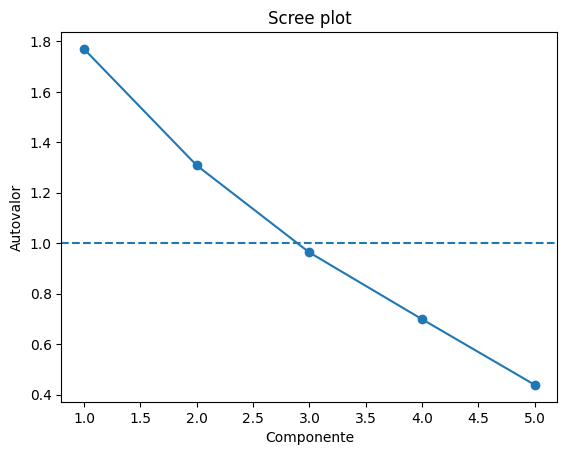

[PCA] Componentes retenidas: 3 (78.06% var. acumulada)


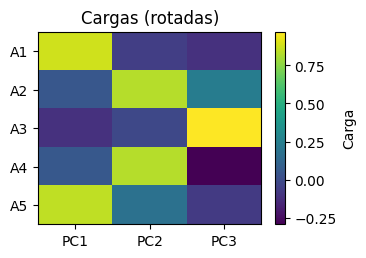


[Matriz total de varianza explicada]



,Autovalor,% Var.Exp,% Var.Acum
Componente,,,
1,1.77,34.19,34.19
2,1.31,25.27,59.46
3,0.96,18.60,78.06



[Comunalidades]



,Comunalidad
A1,0.792
A2,0.751
A3,0.957
A4,0.782
A5,0.760



[Matriz de componentes]



,PC1,PC2,PC3
A1,0.880,-0.061,-0.116
A2,0.049,0.832,0.239
A3,-0.112,-0.020,0.972
A4,0.054,0.832,-0.294
A5,0.850,0.178,-0.077


In [ ]:
info = pca_report(df_piloto, vindependiente1_cols, variance_threshold=0.80)

[PCA] columnas constantes eliminadas: ['G', 'I', 'Q']


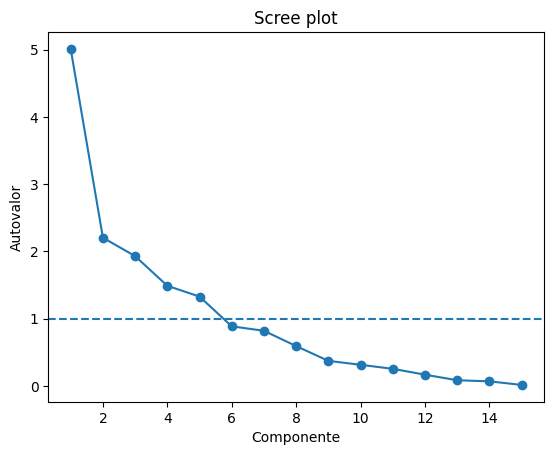

[PCA] Componentes retenidas: 5 (76.99% var. acumulada)


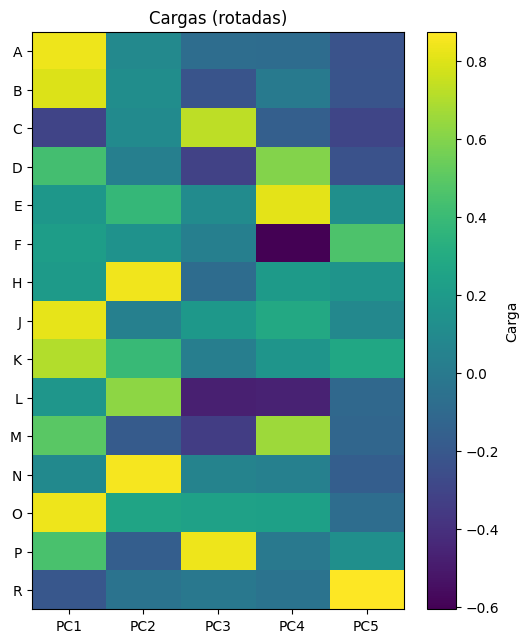


[Matriz total de varianza explicada]



,Autovalor,% Var.Exp,% Var.Acum
Componente,,,
1,5.01,32.25,32.25
2,2.20,14.19,46.43
3,1.93,12.42,58.86
4,1.49,9.58,68.44
5,1.33,8.55,76.99



[Comunalidades]



,Comunalidad
A,0.773
B,0.742
C,0.739
D,0.699
E,0.868
F,0.653
H,0.819
J,0.795
K,0.755
L,0.872



[Matriz de componentes]



,PC1,PC2,PC3,PC4,PC5
A,0.837,0.092,-0.075,-0.083,-0.227
B,0.794,0.119,-0.220,0.001,-0.220
C,-0.302,0.103,0.724,-0.157,-0.296
D,0.430,0.032,-0.313,0.601,-0.232
E,0.180,0.379,0.108,0.815,0.129
F,0.216,0.149,0.034,-0.606,0.464
H,0.202,0.840,-0.084,0.198,0.160
J,0.820,0.040,0.181,0.285,0.083
K,0.706,0.391,0.028,0.163,0.277
L,0.170,0.623,-0.476,-0.467,-0.105


In [ ]:
 info2 = pca_report(df_piloto, vdependiente1_cols, variance_threshold=0.80)

In [56]:
def spearman_test(
        df: pd.DataFrame,
        col_x: str,
        col_y: str,
        alpha: float = 0.05,
        as_ordinal: bool = False
    ) -> dict:
    """
    Calcula la correlación de Spearman entre dos columnas y devuelve:
      • rho                    – coeficiente de Spearman
      • se_asymptotic          – error estándar asintótico
      • t_approx               – estadístico t aproximado (rho / se)
      • pvalue                 – significancia aproximada (dos colas)
      • reject_H0              – True si p < alpha, False en caso contrario

    Parámetros
    ----------
    df : DataFrame con los datos
    col_x, col_y : nombres de las columnas a comparar
    alpha : nivel de significancia (p. ej. 0.05)
    as_ordinal :
        - False (default) → usa los valores numéricos tal cual.
        - True  → trata las columnas como ordinales;
                  si son categóricas las convierte a códigos ordenados.
    """
    # Extraer columnas y eliminar nulos simultáneos
    x = df[col_x]
    y = df[col_y]
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]

    # Si se solicita tratamiento ordinal, convertir a códigos ordenados
    if as_ordinal:
        if pd.api.types.is_categorical_dtype(x):
            x = x.cat.codes
        else:
            x = pd.Categorical(x, ordered=True).codes
        if pd.api.types.is_categorical_dtype(y):
            y = y.cat.codes
        else:
            y = pd.Categorical(y, ordered=True).codes

    n = len(x)
    if n < 3:
        raise ValueError("Se necesitan al menos 3 casos sin NA para Spearman.")

    # Correlación y p-value con SciPy
    rho, p = stats.spearmanr(x, y)

    # Error estándar asintótico (apx. grande-muestra)
    se = 1 / np.sqrt(n - 1)          # ≈√Var(rs)   (Kendall, 1948)

    # Estadístico t aproximado
    t_stat = rho / se                # bajo H0 ~ Normal(0,1) para n grande

    return {
        "rho": rho,
        "se_asymptotic": se,
        "t_approx": t_stat,
        "pvalue": p,
        "reject_H0": p < alpha
    }

In [57]:
df_encuesta_final = df_encuesta[df_encuesta['Tipo'] != 'Piloto']


In [59]:
resultado = spearman_test(
    df=df_encuesta_final,
    col_x="I_Clase",
    col_y="D_Clase",
    alpha=0.05,          # Nivel de significancia deseado
    as_ordinal=False     # Pon True si las dos columnas son ordinales
)

print(resultado)


{'rho': np.float64(0.28071393923767207), 'se_asymptotic': np.float64(0.12909944487358055), 't_approx': np.float64(2.1744008234315695), 'pvalue': np.float64(0.02842596786353933), 'reject_H0': np.True_}


In [67]:
def spearman_test(
        df: pd.DataFrame,
        col_x: str,
        col_y: str,
        alpha: float = 0.05,
        as_ordinal: bool = False
    ) -> dict:
    x = df[col_x]
    y = df[col_y]
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]

    if as_ordinal:
        x = pd.Categorical(x, ordered=True).codes
        y = pd.Categorical(y, ordered=True).codes

    n = len(x)
    if n < 3:
        raise ValueError("Se requieren al menos 3 observaciones pareadas.")

    rho, p = stats.spearmanr(x, y)
    se = 1 / np.sqrt(n - 1)
    t_stat = rho / se

    return {
        "rho": rho,
        "se_asymptotic": se,
        "t_approx": t_stat,
        "pvalue": p,
        "reject_H0": p < alpha,
        "n": n          # <= ESTA CLAVE ES LA QUE FALTABA
    }


In [68]:
# -------------------------------------------------------------
# Pares de columnas a comparar
# -------------------------------------------------------------
alpha = 0.05      # nivel de significancia

# Versión numérica
numeric_pairs = [
    ("D_total",        "I_Total")   # Estado Nutricional vs Factor sociofamiliar
]

# Versión de clase (ordinal)
class_pairs = [
    ("D_Clase", "I_Clase")   # Evaluación_Clase vs Factor sociofamiliar (clase)
]

# -------------------------------------------------------------
# Función auxiliar para imprimir resultados
# -------------------------------------------------------------
def print_result(dep, indep, res, tipo):
    decision = (
        "HAY relación y SE RECHAZA H₀"
        if res["reject_H0"] else
        "NO hay relación (no se rechaza H₀)"
    )
    print(
        f"[{tipo}] {dep} ~ {indep} | "
        f"n={res['n']:>3} | ρₛ={res['rho']:+.3f} | "
        f"p={res['pvalue']:.4f} -> {decision}"
    )

# -------------------------------------------------------------
# Ejecutar análisis
# -------------------------------------------------------------
for dep, indep in numeric_pairs:
    if dep in df_encuesta_final.columns and indep in df_encuesta_final.columns:
        res = spearman_test(df_encuesta_final, indep, dep, alpha=alpha, as_ordinal=False)
        print_result(dep, indep, res, "Numérico")
    else:
        print(f"[Numérico] Columnas no encontradas: {dep} y/o {indep}")

print("-" * 80)

for dep, indep in class_pairs:
    if dep in df_encuesta_final.columns and indep in df_encuesta_final.columns:
        res = spearman_test(df_encuesta_final, indep, dep, alpha=alpha, as_ordinal=True)
        print_result(dep, indep, res, "Clase (ordinal)")
    else:
        print(f"[Clase] Columnas no encontradas: {dep} y/o {indep}")

[Numérico] Columnas no encontradas: D_total y/o I_Total
--------------------------------------------------------------------------------
[Clase (ordinal)] D_Clase ~ I_Clase | n= 61 | ρₛ=+0.281 | p=0.0284 -> HAY relación y SE RECHAZA H₀


In [70]:
# -------------------------------------------------------------
# Helper: Spearman test (numeric OR ordinal) that returns
# rho, asymptotic SE, t-statistic and p-value
# -------------------------------------------------------------
def spearman_test(
        df: pd.DataFrame,
        x_col: str,
        y_col: str,
        alpha: float = 0.05,
        as_ordinal: bool = False
    ) -> dict:
    """
    Computes Spearman correlation between *x_col* and *y_col*.

    Returns
    -------
    dict
        {
            "n": sample size,
            "rho": Spearman correlation,
            "se": asymptotic standard error of rho,
            "t":  rho / se  (approx. t-statistic, df = n-2),
            "pvalue": two-tailed p-value,
            "reject_H0": bool, True if pvalue < alpha
        }
    """
    from scipy.stats import spearmanr
    import numpy as np

    # -----------------------------------------------------------------
    # Pair-wise deletion of NaNs
    # -----------------------------------------------------------------
    d = df[[x_col, y_col]].dropna()
    n = len(d)
    if n < 3:                                                       # not enough data
        return {"n": n, "rho": np.nan, "se": np.nan, "t": np.nan,
                "pvalue": np.nan, "reject_H0": False}

    x = d[x_col]
    y = d[y_col]

    # -----------------------------------------------------------------
    # If ordinal, map categories to their codes so that spearmanr works
    # -----------------------------------------------------------------
    if as_ordinal:
        if pd.api.types.is_categorical_dtype(x):
            x = x.cat.codes
        if pd.api.types.is_categorical_dtype(y):
            y = y.cat.codes

    rho, pvalue = spearmanr(x, y)

    # -----------------------------------------------------------------
    # Asymptotic standard error and t-statistic
    # -----------------------------------------------------------------
    se = np.sqrt((1.0 - rho ** 2) / (n - 1))
    t_stat = rho / se if se != 0 else np.nan

    return {
        "n": n,
        "rho": rho,
        "se": se,
        "t": t_stat,
        "pvalue": pvalue,
        "reject_H0": pvalue < alpha
    }

# -------------------------------------------------------------
# Pretty printer for one result row
# -------------------------------------------------------------
def print_result(dep: str, indep: str, res: dict, tipo: str) -> None:
    """Human-readable one-line summary of the test result."""
    decision = (
        "HAY relación y SE RECHAZA H₀"
        if res["reject_H0"] else
        "NO hay relación (no se rechaza H₀)"
    )
    print(
        f"[{tipo}] {dep} ~ {indep} | "
        f"n={res['n']:>3} | ρₛ={res['rho']:+.3f} | "
        f"SE={res['se']:.3f} | t≈{res['t']:+.2f} | "
        f"p={res['pvalue']:.4f} -> {decision}"
    )

# -------------------------------------------------------------
# Analysis loops (unchanged)
# -------------------------------------------------------------
alpha = 0.05      # significance level

# Numeric version
# Versión numérica
numeric_pairs = [
    ("D_Total",        "I_Total")   # Estado Nutricional vs Factor sociofamiliar
]

# Versión de clase (ordinal)
class_pairs = [
    ("D_Clase", "I_Clase")   # Evaluación_Clase vs Factor sociofamiliar (clase)
]

for dep, indep in numeric_pairs:
    if dep in df_encuesta_final.columns and indep in df_encuesta_final.columns:
        res = spearman_test(df_encuesta_final, indep, dep,
                            alpha=alpha, as_ordinal=False)
        print_result(dep, indep, res, "Numérico")
    else:
        print(f"[Numérico] Columnas no encontradas: {dep} y/o {indep}")

print("-" * 80)

for dep, indep in class_pairs:
    if dep in df_encuesta_final.columns and indep in df_encuesta_final.columns:
        res = spearman_test(df_encuesta_final, indep, dep,
                            alpha=alpha, as_ordinal=True)
        print_result(dep, indep, res, "Clase (ordinal)")
    else:
        print(f"[Clase] Columnas no encontradas: {dep} y/o {indep}")


[Numérico] D_Total ~ I_Total | n= 61 | ρₛ=+0.364 | SE=0.120 | t≈+3.03 | p=0.0039 -> HAY relación y SE RECHAZA H₀
--------------------------------------------------------------------------------
[Clase (ordinal)] D_Clase ~ I_Clase | n= 61 | ρₛ=+0.281 | SE=0.124 | t≈+2.27 | p=0.0284 -> HAY relación y SE RECHAZA H₀


/tmp/ipython-input-2872537549.py:46: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):
/tmp/ipython-input-2872537549.py:48: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


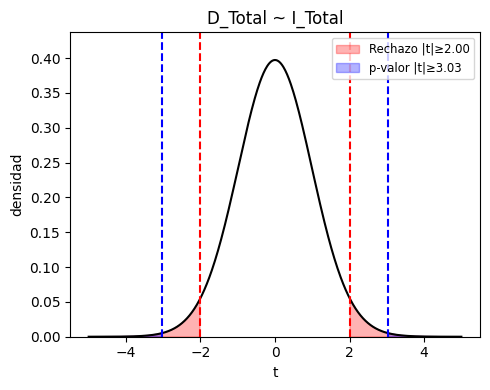

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

alpha = 0.05

numeric_pairs = [
    ("D_Total", "I_Total")
]

# 1) Ejecutar Spearman y recolectar t-stat y df
numeric_results = []
for dep, indep in numeric_pairs:
    if dep in df_encuesta_final and indep in df_encuesta_final:
        res = spearman_test(df_encuesta_final, indep, dep, alpha=alpha, as_ordinal=False)
        df_grados = res["n"] - 2
        numeric_results.append((f"{dep} ~ {indep}", res["t"], df_grados))
    else:
        print(f"[Numérico] Columnas no encontradas: {dep}, {indep}")

# 2) Graficar
if not numeric_results:
    print("No hay resultados numéricos para graficar.")
else:
    fig, axes = plt.subplots(1, len(numeric_results), figsize=(5 * len(numeric_results), 4))
    # Asegurar que axes sea iterable incluso si hay uno solo
    if len(numeric_results) == 1:
        axes = [axes]

    x = np.linspace(-5, 5, 600)
    for ax, (label, t_stat, df_grados) in zip(axes, numeric_results):
        y = t.pdf(x, df_grados)
        ax.plot(x, y, 'k-')

        t_crit = t.ppf(1 - alpha / 2, df_grados)
        ax.fill_between(x, y, where=(x <= -t_crit) | (x >= t_crit),
                        color='red', alpha=0.3, label=f"Rechazo |t|≥{t_crit:.2f}")
        ax.fill_between(x, y, where=(x <= -abs(t_stat)) | (x >= abs(t_stat)),
                        color='blue', alpha=0.3, label=f"p-valor |t|≥{abs(t_stat):.2f}")

        ax.axvline(-t_crit, color='red', linestyle='--')
        ax.axvline(t_crit, color='red', linestyle='--')
        ax.axvline(-t_stat, color='blue', linestyle='--')
        ax.axvline(t_stat, color='blue', linestyle='--')

        ax.set_title(label)
        ax.set_ylim(0, y.max() * 1.1)
        ax.set_xlabel("t")
        ax.set_ylabel("densidad")
        ax.legend(fontsize="small")

    plt.tight_layout()
    plt.show()


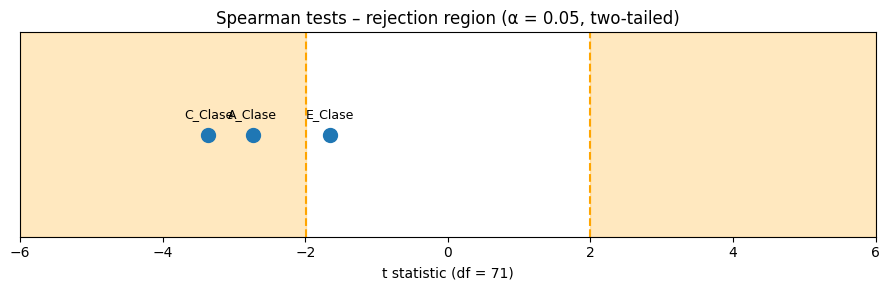

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------
# INPUT: t-statistics for each ordinal pair
# ------------------------------------------------------------------
results = {
    "A_Clase": -2.74,
    "C_Clase": -3.36,
    "E_Clase": -1.65,
}

n = 73              # tamaño de muestra
df = n - 2          # grados de libertad para t aproximada
alpha = 0.05        # nivel de significancia (dos colas)

# ------------------------------------------------------------------
# Valor crítico de t (dos colas). Requiere SciPy; si no, usa 1.99.
# ------------------------------------------------------------------
try:
    from scipy.stats import t
    tcrit = t.ppf(1 - alpha / 2, df)
except Exception:
    tcrit = 1.994  # aproximación para df≈71

# ------------------------------------------------------------------
# PLOT
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 3))

# Zonas de rechazo (sombreado)
ax.axvspan(-6, -tcrit, color="orange", alpha=0.25)
ax.axvspan(tcrit,  6,  color="orange", alpha=0.25)

# Líneas límite
ax.axvline(-tcrit, ls="--", color="orange")
ax.axvline(tcrit,  ls="--", color="orange")

# Puntos de cada contraste
x_vals = list(results.values())
labels = list(results.keys())
ax.scatter(x_vals, np.zeros_like(x_vals), s=100, zorder=3)

# Anotar cada punto
for x, label in zip(x_vals, labels):
    ax.annotate(label, (x, 0), xytext=(0, 12), textcoords="offset points",
                ha="center", fontsize=9)

# Formato
ax.set_xlim(-6, 6)
ax.set_ylim(-1, 1)
ax.set_yticks([])
ax.set_xlabel(f"t statistic (df = {df})")
ax.set_title(f"Spearman tests – rejection region (α = {alpha}, two-tailed)")

plt.tight_layout()
plt.show()


In [75]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# -------------------------------------------------------------
# Helper: Chi-cuadrado de independencia (para variables categóricas)
# -------------------------------------------------------------
def chi_square_test(
        df: pd.DataFrame,
        x_col: str,
        y_col: str,
        alpha: float = 0.05,
        apply_yates: bool = False  # usa corrección de Yates solo para tablas 2x2 si quieres
    ) -> dict:
    """
    Prueba chi-cuadrado de independencia entre x_col e y_col.

    Returns
    -------
    dict: {
        "n": int,                        # muestra tras dropna
        "chi2": float,
        "dof": int,
        "pvalue": float,
        "reject_H0": bool,
        "cramers_v": float,             # tamaño de efecto
        "table_shape": (r, c),
        "pct_expected_lt5": float,      # % de celdas con esperado < 5
        "valid_assumptions": bool,      # regla rápida: <20% esperado <5
        "contingency": pd.DataFrame,    # tabla de contingencia (observados)
    }
    """
    # 1) Limpieza pareada
    d = df[[x_col, y_col]].dropna()
    n = len(d)
    if n == 0:
        return {"n": 0, "chi2": np.nan, "dof": 0, "pvalue": np.nan,
                "reject_H0": False, "cramers_v": np.nan,
                "table_shape": (0, 0), "pct_expected_lt5": np.nan,
                "valid_assumptions": False, "contingency": pd.DataFrame()}

    # 2) Tabla de contingencia
    ct = pd.crosstab(d[y_col], d[x_col])  # filas=y, columnas=x (solo convención)
    r, c = ct.shape
    if r < 2 or c < 2:
        # chi2 requiere al menos 2x2
        return {"n": n, "chi2": np.nan, "dof": 0, "pvalue": np.nan,
                "reject_H0": False, "cramers_v": np.nan,
                "table_shape": (r, c), "pct_expected_lt5": np.nan,
                "valid_assumptions": False, "contingency": ct}

    # 3) Chi-cuadrado
    correction = apply_yates and (r == 2 and c == 2)
    chi2, p, dof, expected = chi2_contingency(ct.values, correction=correction)

    # 4) Supuestos (regla rápida: <20% de celdas con esperado <5)
    pct_lt5 = (expected < 5).sum() / expected.size * 100.0
    valid = pct_lt5 < 20.0

    # 5) Tamaño de efecto: Cramer's V
    phi2 = chi2 / n
    k = min(r, c)
    cramers_v = np.sqrt(phi2 / (k - 1)) if k > 1 else np.nan

    return {
        "n": n,
        "chi2": chi2,
        "dof": dof,
        "pvalue": p,
        "reject_H0": p < alpha,
        "cramers_v": cramers_v,
        "table_shape": (r, c),
        "pct_expected_lt5": pct_lt5,
        "valid_assumptions": valid,
        "contingency": ct
    }

# -------------------------------------------------------------
# Pretty printer para una fila de resultado
# -------------------------------------------------------------
def print_chi_result(dep: str, indep: str, res: dict, tipo: str, alpha: float = 0.05) -> None:
    decision = "HAY relación y SE RECHAZA H₀" if res["reject_H0"] else "NO hay relación (no se rechaza H₀)"
    sup = "OK" if res["valid_assumptions"] else "Atención: supuestos débiles (esperados <5)"
    shape = f"{res['table_shape'][0]}x{res['table_shape'][1]}"
    print(
        f"[{tipo}] {dep} ~ {indep} | n={res['n']} | χ²({res['dof']})={res['chi2']:.2f} "
        f"| p={res['pvalue']:.4f} | V_Cramer={res['cramers_v']:.3f} "
        f"| tabla={shape} | {sup} -> {decision}"
    )

# -------------------------------------------------------------
# Ejemplo de uso (con tus pares ordinales)
# -------------------------------------------------------------
alpha = 0.05
chi_pairs = [
    ("D_Clase", "I_Clase"),  # ambas categóricas/ordinales
]

for dep, indep in chi_pairs:
    if dep in df_encuesta_final.columns and indep in df_encuesta_final.columns:
        res = chi_square_test(df_encuesta_final, indep, dep, alpha=alpha, apply_yates=True)
        print_chi_result(dep, indep, res, "Chi-cuadrado", alpha=alpha)
        # Si quieres ver la tabla:
        # print(res["contingency"])
    else:
        print(f"[Chi] Columnas no encontradas: {dep} y/o {indep}")


[Chi-cuadrado] D_Clase ~ I_Clase | n=61 | χ²(6)=8.19 | p=0.2244 | V_Cramer=0.259 | tabla=3x4 | Atención: supuestos débiles (esperados <5) -> NO hay relación (no se rechaza H₀)


In [ ]:
import pandas as pd
from scipy.stats import shapiro




# 3. Variables a evaluar
variables = ['Global', 'A_Total', 'C_Total', 'E_Total']

# 4. Ejecuta Shapiro–Wilk
results = []
for var in variables:
    datos = df_encuesta_final[var].dropna()
    W, p = shapiro(datos)
    results.append({
        'variable': var,
        'W_stat': round(W, 4),
        'p_value': round(p, 4),
        'normal? (p > 0.05)': p > 0.05
    })

# 5. Muestra la tabla
print(pd.DataFrame(results))


  variable  W_stat  p_value  normal? (p > 0.05)
0   Global  0.9756   0.1672                True
1  A_Total  0.9447   0.0030               False
2  C_Total  0.9368   0.0012               False
3  E_Total  0.9466   0.0038               False
